# 로이스터 뉴스 분류

## 1. 3가지 단어수에 따른 8가지 머신러닝 

In [1]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
def data_load(n_w=None, t_s=0.2):    
    return reuters.load_data(num_words=n_w, test_split=t_s)

(x_train, y_train), (x_test, y_test) = data_load()

In [3]:
print('훈련 샘플의 수:', len(x_train))
print('테스트 샘플의 수:', len(x_test))
print(x_train[0])
print(y_train[0])
num_classes = max(y_train) + 1
print('클래스의 수 :', num_classes)

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246
[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3
클래스의 수 : 46


훈련용 뉴스의 최대 길이 : 2376
훈련용 뉴스의 평균 길이 : 145.5398574927633


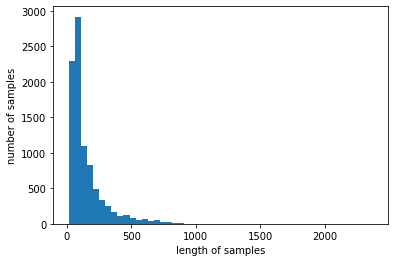

In [4]:
print('훈련용 뉴스의 최대 길이 :', max(len(l) for l in x_train))
print('훈련용 뉴스의 평균 길이 :', sum(map(len, x_train)) / len(x_train))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

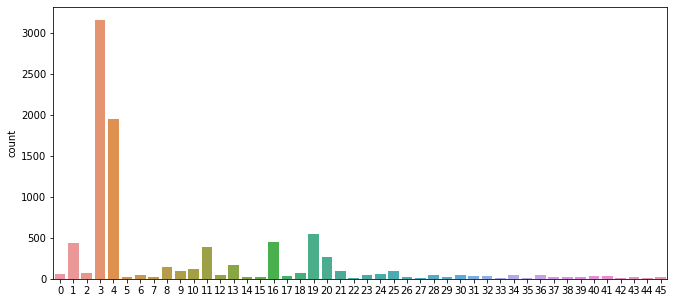

In [5]:
# 라벨 데이터 분포 확인
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

In [6]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


In [7]:
word_to_index = reuters.get_word_index(path="reuters_word_index.json")
index_to_word = { index+3 : word for word, index in word_to_index.items() }
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token
    
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [8]:
# 정수데이터에서 워드로 변환

def decode(x):
    decoded = []
    for i in range(len(x)):
        t = ' '.join([index_to_word[index] for index in x[i]])
        decoded.append(t)
    return decoded

x_train = decode(x_train)
print(len(x_train))
x_test = decode(x_test)
print(len(x_test))

8982
2246


In [9]:
# tf_idf 변환
dtmvector = CountVectorizer()
tfidf_transformer = TfidfTransformer()

def tf_idf(x_t, fit=False):
    global dtmvector, tfidf_transformer
    if fit:
        x_train_dtm = dtmvector.fit_transform(x_t)
        print(x_train_dtm.shape)    
        tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
        print(tfidfv.shape)
    else: 
        x_train_dtm = dtmvector.transform(x_t)
        print(x_train_dtm.shape)    
        tfidfv = tfidf_transformer.transform(x_train_dtm)
        print(tfidfv.shape)
    return tfidfv

tfidfv = tf_idf(x_train, fit=True)

(8982, 26506)
(8982, 26506)


In [10]:
class ClassifierModel:
    def __init__(self, model_name):
        
        self.model = None
        if model_name == 'nb':
            self.model = MultinomialNB()
        
        elif model_name == 'cnb':
            self.model = ComplementNB()
        
        elif model_name == 'lr':
            self.model = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
        
        elif model_name == 'svc':
            self.model = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
        
        elif model_name == 'dtc':
            self.model = DecisionTreeClassifier(max_depth=10, random_state=0)
        
        elif model_name == 'rfc':
            self.model = RandomForestClassifier(n_estimators=5, random_state=0)
            
        elif model_name == 'grc':
            self.model = GradientBoostingClassifier(random_state=0)
            
        elif model_name == 'v':
            self.model = VotingClassifier(estimators=[
                ('lr', LogisticRegression(C=10000, penalty='l2')),
                ('cb', ComplementNB()),
                ('grbt', GradientBoostingClassifier(random_state=0)),
                ('rf', RandomForestClassifier(n_estimators=5, random_state=0))
            ], voting='soft', n_jobs=-1)

        self.predicted = None
        self.y_test = None
        
    def fit(self, x, y):
        print('학습 시작')
        self.model.fit(x, y)
    
    def test(self, x, y):
        self.y_test = y
        self.predicted = self.model.predict(x)
        acc = accuracy_score(y, self.predicted)
        print("정확도:", acc)
        return self.predicted, acc
        
    def result(self):
        report = classification_report(self.y_test, self.predicted, zero_division=0)
        print(report)
        return report
        

In [11]:
model = ClassifierModel('nb')
model.fit(tfidfv, y_train)

학습 시작


In [12]:
tfidfv_test = tf_idf(x_test)
predicted, acc = model.test(tfidfv_test, y_test)
report = model.result()

(2246, 26506)
(2246, 26506)
정확도: 0.5997328584149599
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.79      0.21      0.33       105
           2       0.00      0.00      0.00        20
           3       0.72      0.92      0.81       813
           4       0.45      0.96      0.61       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        30
          11       0.80      0.29      0.42        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.75      

In [13]:
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
    df_cm = pd.DataFrame(confusion_matrix(y_test, predicted))#, index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(12,12))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylabel('label')
    plt.xlabel('predicted value')

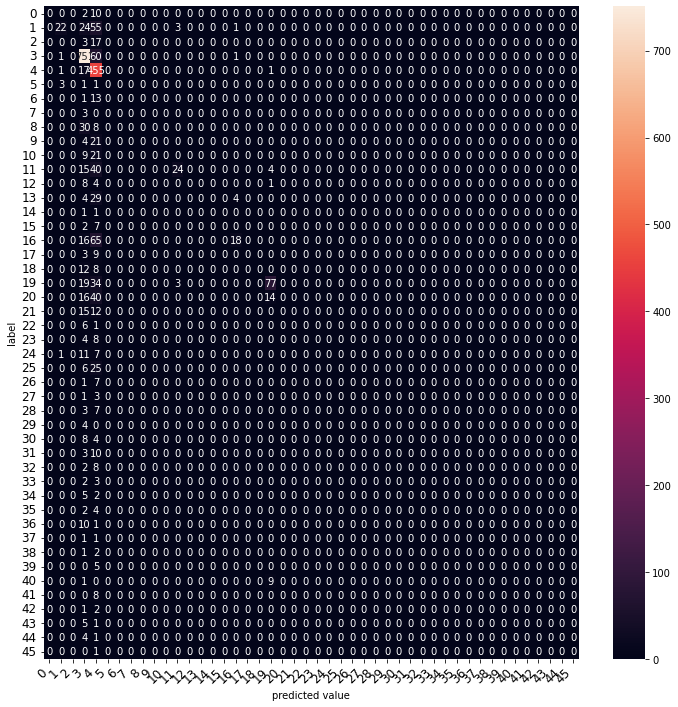

In [14]:
graph_confusion_matrix(predicted, tfidfv_test, y_test)

In [15]:
word_num_list = [None, 5000, 15000]

model_name_list = ['lr', 'nb', 'cnb', 'svc', 'dtc', 'rfc', 'grc', 'v']
for w_n in word_num_list:
    print('vocab size:', w_n)
    (x_train, y_train), (x_test, y_test) = data_load(n_w=w_n)
    
    x_train = decode(x_train)
    x_test = decode(x_test)
    
    tfidfv = tf_idf(x_train, fit=True)
    tfidfv_test = tf_idf(x_test)
    
    for m_n in model_name_list:
        print('model type:', m_n)
        model = ClassifierModel(m_n)
        model.fit(tfidfv, y_train)
        model.test(tfidfv_test, y_test)
        model.result()
        print('------------------------------------------------------------')
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')

vocab size: None
(8982, 26506)
(8982, 26506)
(2246, 26506)
(2246, 26506)
model type: lr
학습 시작
정확도: 0.8165627782724845
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.75      0.79      0.77       105
           2       0.78      0.70      0.74        20
           3       0.92      0.93      0.93       813
           4       0.81      0.88      0.84       474
           5       1.00      0.20      0.33         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.69      0.71      0.70        38
           9       0.85      0.88      0.86        25
          10       0.93      0.90      0.92        30
          11       0.67      0.72      0.69        83
          12       0.57      0.31      0.40        13
          13       0.64      0.62      0.63        37
          14       0.67      1.00      0.80         2
          15     

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


정확도: 0.788512911843277
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.73      0.72      0.73       105
           2       0.75      0.60      0.67        20
           3       0.91      0.92      0.92       813
           4       0.81      0.86      0.83       474
           5       0.00      0.00      0.00         5
           6       0.80      0.86      0.83        14
           7       1.00      0.33      0.50         3
           8       0.64      0.71      0.67        38
           9       0.73      0.76      0.75        25
          10       0.92      0.80      0.86        30
          11       0.70      0.73      0.72        83
          12       0.50      0.38      0.43        13
          13       0.57      0.57      0.57        37
          14       1.00      1.00      1.00         2
          15       0.71      0.56      0.63         9
          16       0.60      0.72      0.65        99
    

정확도: 0.7702582368655387
              precision    recall  f1-score   support

           0       0.60      0.50      0.55        12
           1       0.81      0.71      0.76       105
           2       0.58      0.70      0.64        20
           3       0.87      0.91      0.89       813
           4       0.78      0.86      0.82       474
           5       1.00      0.20      0.33         5
           6       0.77      0.71      0.74        14
           7       1.00      0.33      0.50         3
           8       0.60      0.63      0.62        38
           9       0.91      0.80      0.85        25
          10       0.79      0.77      0.78        30
          11       0.61      0.65      0.63        83
          12       0.50      0.46      0.48        13
          13       0.48      0.32      0.39        37
          14       0.00      0.00      0.00         2
          15       0.25      0.11      0.15         9
          16       0.72      0.71      0.71        99
   

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


정확도: 0.8205699020480854
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.77      0.78      0.78       105
           2       0.70      0.80      0.74        20
           3       0.93      0.94      0.93       813
           4       0.81      0.89      0.85       474
           5       1.00      0.20      0.33         5
           6       0.87      0.93      0.90        14
           7       1.00      0.33      0.50         3
           8       0.71      0.71      0.71        38
           9       0.80      0.80      0.80        25
          10       0.90      0.90      0.90        30
          11       0.67      0.76      0.71        83
          12       0.71      0.38      0.50        13
          13       0.69      0.65      0.67        37
          14       0.50      0.50      0.50         2
          15       0.40      0.22      0.29         9
          16       0.72      0.79      0.75        99
   

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


정확도: 0.7742653606411398
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.71      0.71      0.71       105
           2       0.71      0.75      0.73        20
           3       0.89      0.91      0.90       813
           4       0.81      0.83      0.82       474
           5       0.00      0.00      0.00         5
           6       0.80      0.86      0.83        14
           7       1.00      0.33      0.50         3
           8       0.57      0.63      0.60        38
           9       0.81      0.88      0.85        25
          10       0.85      0.77      0.81        30
          11       0.66      0.75      0.70        83
          12       0.36      0.38      0.37        13
          13       0.52      0.62      0.57        37
          14       1.00      0.50      0.67         2
          15       0.75      0.33      0.46         9
          16       0.65      0.67      0.66        99
   

정확도: 0.767586821015138
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.80      0.68      0.73       105
           2       0.70      0.70      0.70        20
           3       0.90      0.90      0.90       813
           4       0.76      0.83      0.79       474
           5       0.14      0.20      0.17         5
           6       0.93      0.93      0.93        14
           7       0.50      0.33      0.40         3
           8       0.64      0.66      0.65        38
           9       0.91      0.84      0.87        25
          10       0.87      0.87      0.87        30
          11       0.62      0.66      0.64        83
          12       0.46      0.46      0.46        13
          13       0.55      0.43      0.48        37
          14       0.08      0.50      0.14         2
          15       0.33      0.22      0.27         9
          16       0.72      0.77      0.75        99
    

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


정확도: 0.8174532502226179
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.80      0.81      0.81       105
           2       0.75      0.90      0.82        20
           3       0.92      0.94      0.93       813
           4       0.80      0.88      0.84       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.67      0.80         3
           8       0.69      0.71      0.70        38
           9       0.81      0.84      0.82        25
          10       0.93      0.90      0.92        30
          11       0.69      0.75      0.72        83
          12       0.67      0.46      0.55        13
          13       0.68      0.62      0.65        37
          14       0.33      0.50      0.40         2
          15       0.67      0.44      0.53         9
          16       0.72      0.77      0.75        99
   

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


정확도: 0.7827248441674087
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.73      0.71      0.72       105
           2       0.64      0.70      0.67        20
           3       0.90      0.91      0.91       813
           4       0.81      0.85      0.83       474
           5       0.00      0.00      0.00         5
           6       0.87      0.93      0.90        14
           7       1.00      0.33      0.50         3
           8       0.60      0.68      0.64        38
           9       0.91      0.84      0.87        25
          10       0.82      0.77      0.79        30
          11       0.60      0.71      0.65        83
          12       0.33      0.31      0.32        13
          13       0.58      0.51      0.54        37
          14       0.67      1.00      0.80         2
          15       0.42      0.56      0.48         9
          16       0.63      0.75      0.69        99
   

정확도: 0.7707034728406055
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.79      0.70      0.74       105
           2       0.62      0.65      0.63        20
           3       0.88      0.91      0.89       813
           4       0.78      0.84      0.81       474
           5       0.00      0.00      0.00         5
           6       0.83      0.71      0.77        14
           7       1.00      0.67      0.80         3
           8       0.59      0.63      0.61        38
           9       0.86      0.76      0.81        25
          10       0.86      0.80      0.83        30
          11       0.64      0.67      0.66        83
          12       0.35      0.54      0.42        13
          13       0.54      0.41      0.46        37
          14       0.08      0.50      0.13         2
          15       0.38      0.33      0.35         9
          16       0.72      0.74      0.73        99
   

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


정확도: 0.8210151380231523
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.77      0.82      0.79       105
           2       0.76      0.80      0.78        20
           3       0.92      0.93      0.93       813
           4       0.81      0.90      0.85       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.67      0.80         3
           8       0.71      0.71      0.71        38
           9       0.81      0.88      0.85        25
          10       0.90      0.87      0.88        30
          11       0.71      0.75      0.73        83
          12       0.56      0.38      0.45        13
          13       0.69      0.65      0.67        37
          14       0.33      1.00      0.50         2
          15       0.67      0.44      0.53         9
          16       0.72      0.76      0.74        99
   

## 결과
|vocab size None|MultinomialNB|ComplementNB|LogisticRegression|LinearSVC|DecisionTree|RandomForest|GradientBoostin|Voting|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|accuracy|0.60|0.76|0.82|0.79|0.62|0.65|0.77|0.82|
|f1-score avg|0.07|0.46|0.67|0.64|0.15|0.28|0.57|0.66|

---
|vocab size 5000|MultinomialNB|ComplementNB|LogisticRegression|LinearSVC|DecisionTree|RandomForest|GradientBoostin|Voting|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|accuracy|0.67|0.77|0.80|0.77|0.62|0.70|0.77|0.82|
|f1-score avg|0.11|0.48|0.65|0.62|0.18|0.36|0.58|0.65|

---
|vocab size 15000|MultinomialNB|ComplementNB|LogisticRegression|LinearSVC|DecisionTree|RandomForest|GradientBoostin|Voting|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|accuracy|0.63|0.77|0.81|0.78|0.62|0.67|0.77|0.82|
|f1-score avg|0.09|0.47|0.67|0.64|0.18|0.30|0.57|0.66|

---

 - 전반적으로 vocab size에 따른 변화는 크게 없었으나 vocab size가 5000일때 f1-score가 좀 더 높아진 모델들이 있으나 기본적으로 워낙 낮았기 때문에 크게 유의미하게 보이지 않음
 - vorting과 logistic모델이 성능이 좋았으며 f1-score도 높음
 - 최종적으로 vocab size가 None일 때 logistic모델이 acc 0.82 f1-score평균 0.67로 가장 높은 성능을 보임

## 2. lstm 모델

In [16]:
# lstm 모델 준비
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
# 데이터 준비
vocab_size = 5000
(x_train, y_train), (x_test, y_test) = data_load(n_w=vocab_size)

max_len = 500
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
print(x_train[0])
print(x_test[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [18]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train[0])
print(y_test[0])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [19]:
val_len = int(len(x_train) * 0.2)
x_train, x_val = x_train[:-val_len], x_train[-val_len:]
y_train, y_val = y_train[:-val_len], y_train[-val_len:]

In [20]:
# 모델 작성
embedding_dim = 128
hidden_units = 128
num_classes = 46

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         640000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 46)                5934      
Total params: 777,518
Trainable params: 777,518
Non-trainable params: 0
_________________________________________________________________


In [22]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
history = model.fit(x_train, y_train, batch_size=128, epochs=30, callbacks=[es], validation_data=(x_val, y_val))

Epoch 1/30
57/57 [==============================] - 11s 43ms/step - loss: 2.6665 - acc: 0.3387 - val_loss: 2.3802 - val_acc: 0.3447
Epoch 2/30
57/57 [==============================] - 2s 34ms/step - loss: 2.1096 - acc: 0.4589 - val_loss: 1.9788 - val_acc: 0.4504
Epoch 3/30
57/57 [==============================] - 2s 33ms/step - loss: 1.7849 - acc: 0.5381 - val_loss: 1.7301 - val_acc: 0.5557
Epoch 4/30
57/57 [==============================] - 2s 34ms/step - loss: 1.8114 - acc: 0.5284 - val_loss: 1.8147 - val_acc: 0.5150
Epoch 5/30
57/57 [==============================] - 2s 34ms/step - loss: 1.6917 - acc: 0.5646 - val_loss: 1.6612 - val_acc: 0.5741
Epoch 6/30
57/57 [==============================] - 2s 33ms/step - loss: 1.5264 - acc: 0.6099 - val_loss: 1.6026 - val_acc: 0.5863
Epoch 7/30
57/57 [==============================] - 2s 33ms/step - loss: 1.4149 - acc: 0.6340 - val_loss: 1.5796 - val_acc: 0.6013
Epoch 8/30
57/57 [==============================] - 2s 34ms/step - loss: 1.3153 - 

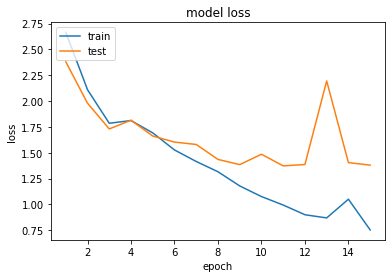

In [23]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
predicted = model.predict(x_test)
for idx, p in enumerate(predicted):
    predicted[idx] = [1 if i == p.argmax() else 0 for i in range(len(p))]

acc = accuracy_score(y_test, predicted)
print("정확도:", acc)

report = classification_report(y_test, predicted, zero_division=0)
print(report)

정확도: 0.6763134461264471
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.52      0.57      0.54       105
           2       0.29      0.10      0.15        20
           3       0.92      0.94      0.93       813
           4       0.82      0.82      0.82       474
           5       0.00      0.00      0.00         5
           6       1.00      0.07      0.13        14
           7       0.00      0.00      0.00         3
           8       0.33      0.45      0.38        38
           9       0.22      0.60      0.32        25
          10       0.22      0.50      0.31        30
          11       0.51      0.57      0.53        83
          12       0.00      0.00      0.00        13
          13       0.14      0.19      0.16        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.43      0.60      0.50        99
   

## lstm모델과 비교
---
 - 최종적으로는 vocab size가 None일 때 logistic모델이 가장 높았으나 전반적으로는 vocab size가 5000일 때 좀 더 높은 경향이 있어 5000으로 진행
 - 최대한 같은 조건을 맞추기 위해 전처리는 긴 문장만 처리하여 자름
 - lstm모델의 결과로 acc 0.68 f1-score평균 0.17로 측정되었으며 전반적으로 머신러닝 중 제일 낮은 성능을 보인 MultinomialNB과 비슷함
 - 기본적인 머신러닝이 성능이 매우 앞섬